In [1]:
import glob
import numpy as np
import scipy as sp
import einops as eo
import matplotlib.pyplot as plt
import math
import plotly.graph_objects as go
from scipy.spatial.transform import Rotation


M0 = 1480 #mT
shape = [3*25.4/16, 25.4/8] #radius and height
x0 = np.array([0,0,10, 0,0,1])

In [2]:
def B_dipole(position, rotation, M0, shape):
    R = np.sqrt(np.sum(position**2, axis=1))
    B = (M0 * (shape[0]) ** 2 * shape[1] / (16)) * (
        (
            3
            * position
            / R[:, np.newaxis] ** 5
            * (eo.einsum(position, rotation, "sensor dim,  dim -> sensor"))[
                :, np.newaxis
            ]
        )
        - rotation[np.newaxis, :] / (R[:, np.newaxis] ** 3)
    )
    return B


def getField_dipole(x, positions, M0, shape):
    position = x[:3]
    axis = x[3:]
    return B_dipole(positions - position, axis, M0, shape)


def getField_dipole_fixed(x, positions, M0, shape):
    position = x[:3]
    axis = x[3:]
    return B_dipole(positions - position, axis, M0, shape)


def cost_dipole(x, B, positions, M0, shape):
    diff = getField_dipole(x, positions, M0, shape) - B
    return np.sum((diff) ** 2)


def minimize(x0, B, positions, M0, shape, *args):
    #print("Starting mimimization")
    b_args = (B, positions, M0, shape)
    cons = [{"type": "eq", "fun": lambda x: x[3] ** 2 + x[4] ** 2 + x[5] ** 2 - 1}]
    bounds = [(-100, 100), (-100, 100), (0, 100), (-1, 1), (-1, 1), (-1, 1)]
    res = sp.optimize.minimize(
        fun=cost_dipole, x0=x0, args=b_args, tol=1e-100, constraints=cons, bounds=bounds, *args
    ).x  
    #print(f"Finished mimimization with shape {b_args[3]} at {res}")
    return res

def circle_radius(x1, y1, x2, y2, x3, y3):
    # Calculate lengths of sides of the triangle formed by the three points
    a = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    b = math.sqrt((x3 - x2) ** 2 + (y3 - y2) ** 2)
    c = math.sqrt((x3 - x1) ** 2 + (y3 - y1) ** 2)

    # Calculate the semi-perimeter of the triangle
    s = (a + b + c) / 2

    # Calculate the area of the triangle using Heron's formula
    area = math.sqrt(s * (s - a) * (s - b) * (s - c))

    # Calculate the radius of the circle using the formula: radius = (abc) / (4 * area)
    radius = (a * b * c) / (4 * area)
    
    return radius

def comparison_plot(locact, locpred, axis, relative):

    if axis == 'x':
        ax = 0
    elif axis == 'y':
        ax = 1
    else:
        ax = 2

    index = list(range(len(locact[:,ax])))
    act = locact[:, ax]
    pred = locpred[:, ax]

    rel = ''

    if relative==True:
        act = [x - locact[0, ax] for x in locact[:, ax]]
        pred = [x - locpred[0, ax] for x in locpred[:, ax]]
        rel = ' (Relative)'

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.scatter(index, pred, label='Predicted' + rel)
    plt.scatter(index, act, label='Actual' + rel)
    plt.xlabel('Index')
    plt.ylabel(axis + '-component')
    plt.title('Comparison of '+axis+ ' Location' + rel+ ': Predicted vs Actual')
    plt.legend()
    plt.grid(True)
    plt.show()

    return

def comp_plot3D(locact, locpred, xact, yact, axis, relative):

    if axis == 'x':
        ax = 0
    elif axis == 'y':
        ax = 1
    else:
        ax = 2

    index = list(range(len(locact[:,ax])))
    act = locact[:, ax]
    pred = locpred[:, ax]

    rel = ''

    if relative==True:
        act = [x - locact[0, ax] for x in locact[:, ax]]
        pred = [x - locpred[0, ax] for x in locpred[:, ax]]
        rel = ' (Relative)'

    fig = go.Figure(data=[
        go.Scatter3d(x=xact, y=yact, z=pred, name='Predicted' + rel),
        go.Scatter3d(x=xact, y=yact, z=act, name='Actual' + rel)])
    fig.show()

    return

def displacement_plot(actual, predicted):

    dispx = np.array(predicted[:,0]-predicted[:,0][0])
    dispy = np.array(predicted[:,1]-predicted[:,1][0])
    dispz = np.array(predicted[:,2]-predicted[:,2][0])
    disp = np.sqrt(dispx**2+dispy**2+dispz**2)
    actdispx = np.array(actual[:,0]-actual[:,0][0])
    actdispy = np.array(actual[:,1]-actual[:,1][0])
    actdispz = np.array(actual[:,2]-actual[:,2][0])
    actdisp = np.sqrt(actdispx**2+actdispy**2+actdispz**2)

    plt.figure(figsize=(8, 6))
    plt.scatter(list(range(len(disp))), disp, label='Predicted Displacement')
    plt.scatter(list(range(len(actdisp))), actdisp, label='Actual Displacement')
    plt.xlabel('Index')
    plt.ylabel('Displacement (mm)')
    plt.title('Magnet Displacement')
    plt.legend()
    plt.grid(True)
    plt.show()

    return

def importfitting(folder):

    file_list = sorted(glob.glob(f'{folder}/*.npz'))
    len(file_list)
    data = np.load(file_list[0])
    pos = data['pos'][0]

    locpred = [np.array([0,0,0])]
    anglepred = [np.array([0,0,0])]
    Bstdev = [np.array(pos)]
    for x in range(len(file_list)):
        data = np.load(file_list[x])
        mags = data['mags']
        pos = data['pos'][0]
        B = np.mean(mags, axis=0)
        mags_stdev = np.std(mags, axis=0)
        x_res = minimize(x0, B, pos, M0, shape)
        locpred = np.append(locpred, [x_res[0:3]], axis=0)
        anglepred = np.append(anglepred, [x_res[3:6]], axis=0)
        Bstdev = np.append(Bstdev, [mags_stdev], axis=0)
    locpred = np.delete(locpred, 0, axis=0)
    anglepred = np.delete(anglepred, 0, axis=0)
    Bstdev = np.delete(Bstdev, 0 ,axis=0)

    return mags, locpred, anglepred, Bstdev

def actualangle(xind, yind, xscal, xcon, yscal, ycon, isoff):

    angact = [np.array([0, 0, 0])]
    for y in range(yind):
        for x in range(xind):
            R = Rotation.from_euler('ZYX' ,np.array([0, yscal*y-ycon, xscal*x-xcon]), degrees=True)
            norm = np.array([[0, 0, 1]])
            rotated = R.apply(norm, inverse=False)[0]
            #add = np.array([np.sin(np.deg2rad(2*y-4)), -np.sin(np.deg2rad(2*x-4)), np.cos(np.deg2rad(2*y-4))*np.cos(np.deg2rad(2*x-4))])
            angact = np.append(angact, [rotated], axis=0)
    angact = np.delete(angact, 0, axis=0)
    locact = angact*isoff

    return angact, locact

In [27]:
folder = r"C:\Users\Brandon Nguyen\Documents\Github\magnetic-sensor-data\MLX06112024_10mmAboveIsocenter"
mags, locpred, anglepred, Bstdev = importfitting(folder)
np.append(locpred, anglepred, axis=1)
print(anglepred)


[[-0.04052636  0.07818597  0.99611474]
 [-0.04368994  0.10825726  0.9931624 ]
 [-0.04665209  0.13649356  0.98954186]
 [-0.04909459  0.16270246  0.98545301]
 [-0.05062458  0.18947626  0.98057937]
 [-0.07199728  0.07781271  0.99436491]
 [-0.07423181  0.10741571  0.99143911]
 [-0.07659938  0.13497694  0.98788348]
 [-0.07794763  0.15985206  0.98405868]
 [-0.07885079  0.18523126  0.97952638]
 [-0.10284265  0.07497838  0.99186775]
 [-0.10541647  0.10532338  0.98883485]
 [-0.10587538  0.13095341  0.98571883]
 [-0.10726697  0.15587297  0.98193554]
 [-0.10794822  0.17995065  0.9777346 ]
 [-0.13322663  0.07304447  0.98839019]
 [-0.13478325  0.10351285  0.98545348]
 [-0.13566985  0.12816668  0.98242913]
 [-0.1360571   0.15188655  0.97898873]
 [-0.13643441  0.17709714  0.97469085]
 [-0.16198183  0.06881367  0.98439147]
 [-0.16230899  0.09728666  0.98193233]
 [-0.1625241   0.12433392  0.97883962]
 [-0.16256868  0.14816058  0.97551005]
 [-0.16290631  0.1731576   0.97132795]]


In [25]:
z = np.arccos(anglepred[:,2])*180/np.pi
xy = np.arcsin(anglepred[:, 0:2])*180/np.pi
print(z)
print(xy)

[ 5.05229373  6.70404953  8.29361912  9.78480368 11.310314    6.08544344
  7.50252528  8.92824603 10.24420851 11.61391622  7.31202672  8.56988274
  9.69477582 10.90701777 12.11328726  8.73919074  9.78464401 10.7565315
 11.76595309 12.91804071 10.13643296 10.90799138 11.80777893 12.70638072
 13.75340404]
[[-2.32262547  4.48430294]
 [-2.50404643  6.21486388]
 [-2.67393819  7.84499393]
 [-2.81404377  9.36379173]
 [-2.90181495 10.92222073]
 [-4.12871254  4.46285142]
 [-4.25708523  6.16636379]
 [-4.39312452  7.75728623]
 [-4.47060535  9.19830957]
 [-4.5225121  10.67461568]
 [-5.90288676  4.29997986]
 [-6.05116145  6.04579811]
 [-6.0776034   7.52468982]
 [-6.1577921   8.96742943]
 [-6.19705311 10.36688522]
 [-7.65608669  4.18887045]
 [-7.74608659  5.9414925 ]
 [-7.79735595  7.36366487]
 [-7.81975145  8.73627073]
 [-7.84157301 10.20072179]
 [-9.32194749  3.94585122]
 [-9.34094362  5.5829455 ]
 [-9.35343453  7.14229206]
 [-9.35602297  8.52034466]
 [-9.37562928  9.97145955]]


In [4]:
print(mags)

[[[-0.6468    0.6495    1.30922 ]
  [-0.1074    0.774     1.748692]
  [ 0.5412    0.7635    1.571548]
  [ 0.8241    0.5136    1.00672 ]
  [-0.7989    0.1278    1.72062 ]
  [-0.1467    0.1359    2.270444]
  [ 0.7062    0.1218    2.147992]
  [ 1.0482    0.0582    1.28744 ]
  [-0.7506   -0.582     1.614624]
  [-0.1332   -0.6891    2.133472]
  [ 0.66     -0.6435    1.917124]
  [ 0.9432   -0.4668    1.174668]
  [-0.4947   -0.8361    0.994136]
  [-0.0993   -1.0065    1.30922 ]
  [ 0.447    -0.9678    1.175636]
  [ 0.6837   -0.6951    0.742456]]

 [[-0.6441    0.6495    1.310188]
  [-0.108     0.7725    1.751112]
  [ 0.5388    0.7644    1.573484]
  [ 0.8232    0.5124    1.0043  ]
  [-0.7977    0.1281    1.719168]
  [-0.1461    0.1353    2.268992]
  [ 0.7068    0.1212    2.15138 ]
  [ 1.0491    0.0594    1.287924]
  [-0.7512   -0.5829    1.61172 ]
  [-0.132    -0.6876    2.13444 ]
  [ 0.66     -0.6423    1.916156]
  [ 0.9459   -0.468     1.170312]
  [-0.4929   -0.8361    0.997524]
  [-0.0981  

In [5]:
actang = [np.array([0, 0, 0])]
xact = [np.array([0])]
yact = [np.array([0])]
for y in range(5):
    for x in range(5):
        R = Rotation.from_euler('ZYX' ,np.array([0, -2*y+4, -2*x+4]), degrees=True)
        norm = np.array([[0, 0, 1]])
        rotated = R.apply(norm, inverse=False)[0]
        #add = np.array([np.sin(np.deg2rad(2*y-4)), -np.sin(np.deg2rad(2*x-4)), np.cos(np.deg2rad(2*y-4))*np.cos(np.deg2rad(2*x-4))])
        actang = np.append(actang, [rotated], axis=0)
        xact = np.append(xact, [-2*y+4])
        yact = np.append(yact, [-2*x+4])
actang = np.delete(actang, 0, axis=0)
xact = np.delete(xact, 0, axis=0)
yact = np.delete(yact, 0, axis=0)
locact = actang*12
np.sum(actang**2)
print(actang)
print(xact)
print(yact)

[[ 0.06958655 -0.06975647  0.99513403]
 [ 0.06971398 -0.0348995   0.99695636]
 [ 0.06975647  0.          0.99756405]
 [ 0.06971398  0.0348995   0.99695636]
 [ 0.06958655  0.06975647  0.99513403]
 [ 0.03481448 -0.06975647  0.99695636]
 [ 0.03487824 -0.0348995   0.99878203]
 [ 0.0348995   0.          0.99939083]
 [ 0.03487824  0.0348995   0.99878203]
 [ 0.03481448  0.06975647  0.99695636]
 [ 0.         -0.06975647  0.99756405]
 [ 0.         -0.0348995   0.99939083]
 [ 0.          0.          1.        ]
 [ 0.          0.0348995   0.99939083]
 [ 0.          0.06975647  0.99756405]
 [-0.03481448 -0.06975647  0.99695636]
 [-0.03487824 -0.0348995   0.99878203]
 [-0.0348995   0.          0.99939083]
 [-0.03487824  0.0348995   0.99878203]
 [-0.03481448  0.06975647  0.99695636]
 [-0.06958655 -0.06975647  0.99513403]
 [-0.06971398 -0.0348995   0.99695636]
 [-0.06975647  0.          0.99756405]
 [-0.06971398  0.0348995   0.99695636]
 [-0.06958655  0.06975647  0.99513403]]
[ 4  4  4  4  4  2  2  2

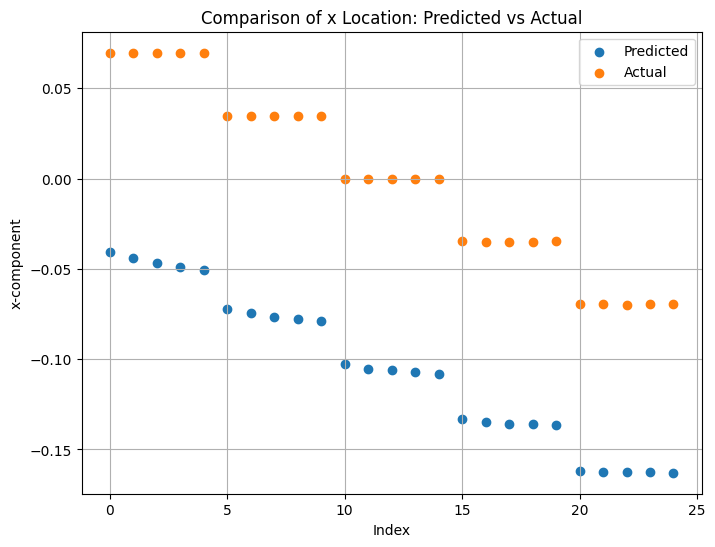

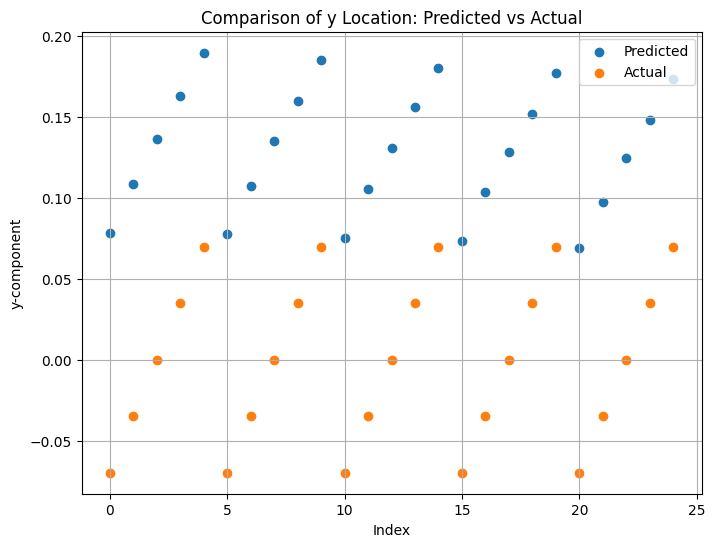

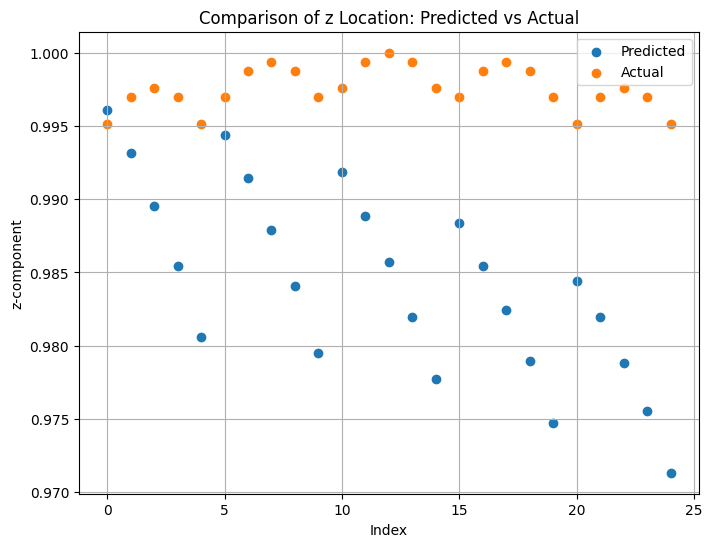

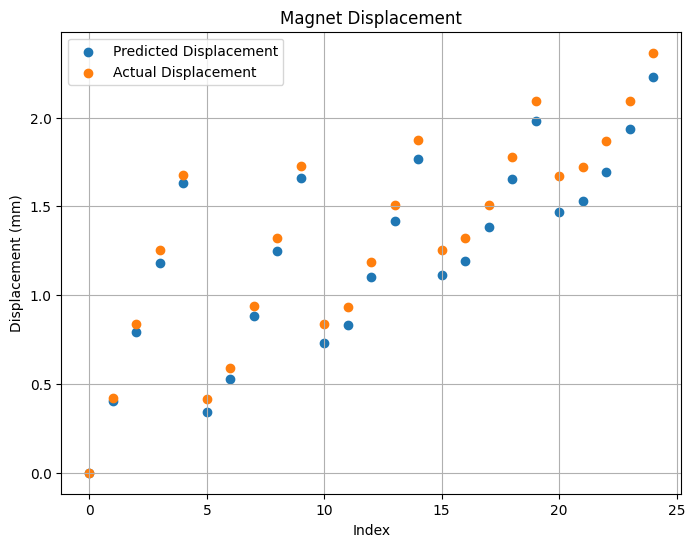

In [6]:
comparison_plot(actang, anglepred, axis='x', relative=False)
comparison_plot(actang, anglepred, axis='y', relative=False)
comparison_plot(actang, anglepred, axis='z', relative=False)
displacement_plot(locact, locpred)

In [7]:
comp_plot3D(actang, anglepred, xact, yact, axis='x', relative=False)
comp_plot3D(actang, anglepred, xact, yact, axis='y', relative=False)
comp_plot3D(actang, anglepred, xact, yact, axis='z', relative=False)

In [8]:
fig = go.Figure(data=go.Cone(x=locpred[:,0], y=locpred[:,1], z=locpred[:,2], u=anglepred[:,0], v=anglepred[:,1], w=anglepred[:,2], 
                             sizemode="absolute", sizeref=2))

fig.update_layout(scene_camera_eye=dict(x=-0.76, y=1.8, z=0.92))

fig.show()

Rotated about Z-axis. Displacement only had a range of 0.06mm over entire rotation. X and Y-components of displacement varied up to 0.3mm. Z-component of angle was always 0.99. 

Do measurements forward to back to try to identify drift.
Make new mount with new magnet (D21B-N52) to have top of magnet at isocenter.
Redo fitting with center sensors (or any combination) to see if results are better.
Goal is 0.2mm